# CMM307 - Advanced Artificial Intelligence
### ***(Valentin Kiss - 1608118)***

In [120]:
# Import libraries used throughout the notebook
import re

import pandas as pd
import numpy as np
import nltk

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from lbl2vec import Lbl2Vec

import matplotlib.pyplot as plt

## Section 1 - Dataset

(Identify the problem and why an NLP solution is needed. Make reference to the dataset)

### Exploratory Data Analysis

***Load and Explore the dataset***

In [2]:
# Load the train & test datasets into a Pandas DF
train_df = pd.read_csv('./ag_news_data/train.csv')
test_df = pd.read_csv('./ag_news_data/test.csv')

In [3]:
# Output the first few rows in the dataset
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
# Rename columns
train_df.columns = ['class', 'title', 'description']
test_df.columns = ['class', 'title', 'description']

In [6]:
# Output the shape of both the train and test DFs
print(f'Training data shape: {train_df.shape}')
print(f'Testing data shape: {test_df.shape}')

Training data shape: (120000, 3)
Testing data shape: (7600, 3)


In [7]:
# Output class distribution for train / test data
print(train_df['class'].value_counts())
print(test_df['class'].value_counts())

class
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64
class
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64


In [9]:
# Check the length of news article descriptions in both train and test sets
print(train_df['description'].apply(len).describe())
print(test_df['description'].apply(len).describe())

count    120000.000000
mean        193.388517
std          64.472066
min           6.000000
25%         155.000000
50%         188.000000
75%         219.000000
max         985.000000
Name: description, dtype: float64
count    7600.000000
mean      192.408026
std        63.192774
min        37.000000
25%       154.000000
50%       187.000000
75%       218.000000
max       830.000000
Name: description, dtype: float64


### Text Pre-Processing

In [15]:
# Create the Preprocessing class

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

class BasicPreProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, stem=False, lem=False):
        self.stem = stem
        self.lem = lem
        self.stopwords = stopwords.words('english')
        self.stopwords.extend(['com', 'lt', 'gt', 'quot']) # extend stopwords with words specific to this dataset

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self._preprocess)

    def _preprocess(self, text):
        text = re.sub(r'target=\S+|HREF=\S+', '', text) # remove HREF & Target attributes for URLs
        token_text = word_tokenize(text) # break down text into individual tokens
        normd_text = [token.lower() for token in token_text if token.isalpha()] # convert to lower-case and remove digits & special characters
        swr_text = [token for token in normd_text if token not in self.stopwords] # remove stopwords to keep attention on words that are meaningful

        if self.stem: # if stemming is set to True
            stemmer = SnowballStemmer("english") # instantiate a Snowball Stemmer
            stemmed_text = [stemmer.stem(word) for word in swr_text]
            return ' '.join(stemmed_text) # return the processed text

        if self.lem: # if lemmatization is set to True
            lem = WordNetLemmatizer() # Instantiate a Word Net Lemmatizer
            lemmatized_text = [lem.lemmatize(word) for word in swr_text]
            return ' '.join(lemmatized_text) # return the processed text
            
        return ' '.join(swr_text) # return the processed text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Use a sample description from the dataset to test the pre-processor
sample_text = ' CHICAGO (Reuters) - Cosmetics manufacturer Estee Lauder  Cos. Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=EL.N target=/stocks/quickinfo/fullquote"&gt;EL.N&lt;/A&gt; on Tuesday posted a bigger quarterly profit,  bolstered by sales in Europe and an improving U.S. retail  market.'

basic_pre_processor = BasicPreProcessor()
lem_pre_processor = BasicPreProcessor(lem=True)
stem_pre_processor = BasicPreProcessor(stem=True)

print(f"Basic Pre-Processing: {basic_pre_processor._preprocess(sample_text)}")
print(f"Lem Pre-Processing: {lem_pre_processor._preprocess(sample_text)}")
print(f"Stem Pre-Processing: {stem_pre_processor._preprocess(sample_text)}")

Basic Pre-Processing: chicago reuters cosmetics manufacturer estee lauder tuesday posted bigger quarterly profit bolstered sales europe improving retail market
Lem Pre-Processing: chicago reuters cosmetic manufacturer estee lauder tuesday posted bigger quarterly profit bolstered sale europe improving retail market
Stem Pre-Processing: chicago reuter cosmet manufactur este lauder tuesday post bigger quarter profit bolster sale europ improv retail market


In [20]:
# Pre-process the texts (title & description) in the training data and save it in add it in a new column
train_df['processed_text'] = basic_pre_processor.fit_transform(train_df['title'] + '. ' + train_df['description'])
train_df.head()

,class,title,description,processed_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bears claw back black reuters reuters wal...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace reut...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks outlook reuters reute...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar record posing new menace us ec...


In [25]:
train_df['processed_text'].apply(len).describe()

count    120000.000000
mean        168.528517
std          44.700766
min           8.000000
25%         140.000000
50%         166.000000
75%         193.000000
max         697.000000
Name: processed_text, dtype: float64

In [36]:
# Pre-process the texts (title & description) in the test data and save it in add it in a new column
test_df['processed_text'] = basic_pre_processor.fit_transform(test_df['title'] + '. ' + test_df['description'])
test_df.head()

,class,title,description,processed_text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears n pension talks unions representing work...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",race second private team sets launch date huma...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,company wins grant study peptides ap ap compan...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires ap ap...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aims limit smog ap ap southern californi...


## Section 2 - Representation Learning

(Write more about the 2 approaches taken for learning representations)

### TF-IDF 

In [37]:
# First representation - TF-IDF
tfidf_text_representation = Pipeline(
    [
        ('count_vectorizer', CountVectorizer(max_features=400)),
        ('tfidf_transformer', TfidfTransformer())
    ]
)

tfidf_train_repr = tfidf_text_representation.fit_transform(train_df['processed_text']).toarray()

print(tfidf_train_repr)
print(tfidf_train_repr.shape)

tfidf_test_repr = tfidf_text_representation.fit_transform(test_df['processed_text']).toarray()

print(tfidf_test_repr)
print(tfidf_test_repr.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.56908003 0.        ]]
(120000, 400)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.30646035 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7600, 400)


### Glove Embeddings

In [58]:
# Create embeddings on a reduced training data
target_size = 40000
test_size = 1 - (target_size / len(train_df))
train_df_reduced, _ = train_test_split(train_df, test_size=test_size, stratify=train_df['class'])

print(train_df_reduced['class'].value_counts())

class
2    10000
4    10000
1    10000
3     9999
Name: count, dtype: int64


In [75]:
# Second representation - Glove

texts = train_df['processed_text']
target = train_df['class']

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1 # calculate the length of the total vocab in the training set
print(vocab_length)

59837


In [76]:
# Glove embeddings - use the pre-trained glove embeddings (with dimensionality of 50) to map words to their corresponding vector
# representations
embeddings_dictionary = dict()
embedding_dim = 50

with open('./glove_pre_trained/glove.6B.50d.txt', encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(59837, 50)

## Section 3 - Baseline Algorithms

(Write more about the choosen algorithms (kNN & Bidirectional LSTM))

### K-Nearest Neighbors (kNN) with TF-IDF

In [39]:
knn_tfidf_cls = KNeighborsClassifier(n_neighbors=5)
accuracy_scores = []

x = tfidf_train_repr
y = train_df['class']

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  knn_tfidf_cls.fit(x_train, y_train)
  predictions = knn_tfidf_cls.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  accuracy_scores.append(acc)

print(accuracy_scores)

[0.710625, 0.736625, 0.7390833333333333, 0.7417916666666666, 0.7152916666666667]


In [99]:
# Train the kNN classifier on the full training set then make prediction on the test set
knn_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=400)),
    ('tfidf_transformer', TfidfTransformer()),  # Transform counts to TF-IDF
    ('knn_classifier', KNeighborsClassifier(n_neighbors=5))
])

#knn_pipeline.fit(train_df['processed_text'], train_df['class'])
#preds = knn_pipeline.predict(test_df['processed_text'])
#print(accuracy_score(preds, test_df['class']))
#print(f1_score(test_df['class'], preds, average='macro'))

### Bidirectional LSTM with Glove Embeddings

In [77]:
longest_train_text = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
print(longest_train_text)

bush visits canada tour us president george bush visiting ottawa today first stop tour takes europe early next year first official visit canada since becoming president four years ago skipped canada favour visiting mexico start first term office cancelled state visit canada last year canadians got vocal opposition iraq conflict cbc news reports purpose visit may smooth relations damaged war iraq trade disputes canadian beef softwood lumber bush also expected ask martin stronger longer commitment peacekeeping afghanistan help organizing elections rebuilding political institutions iraq cbc news also speculates bush may offer definitive timetable reopening border canada cattle


In [78]:
len_longest_text = len(word_tokenize(longest_train_text))
print(len_longest_text)

97


In [79]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

train_padded_sentences = pad_sequences(
    embed(texts), 
    len_longest_text, 
    padding='post'
)

print(train_padded_sentences.shape)

test_padded_sentences = pad_sequences(
    embed(test_df['processed_text']), 
    len_longest_text, 
    padding='post'
)

print(test_padded_sentences.shape)

(120000, 97)
(7600, 97)


In [82]:
bidirectional_lstm_model = keras.Sequential(
    [
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights= [embedding_matrix]),
        keras.layers.Bidirectional(LSTM(len_longest_text, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(1024, activation='relu'),
        Dropout(0.25),
        Dense(512, activation='relu'),
        Dropout(0.25),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(4, activation='softmax')
    ]
)

bidirectional_lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       2,991,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,991,850 (11.41 MB)

 Trainable params: 2,991,850 (11.41 MB)

 Non-trainable params: 0 (0.00 B)

## Section 4 - Evaluation & Discussion of Results

### Evaluation of the kNN classifier with TF-IDF text representation

In [107]:
# KNeighborsClassifier cross-validation using the training data
accuracy_scores = []

x = train_df['processed_text']
y = train_df['class']

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  knn_pipeline.fit(x_train, y_train)
  predictions = knn_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  accuracy_scores.append(acc)

# print(accuracy_scores)
print(f'Cross-validation mean accuracy score: {np.mean(accuracy_scores):.2f}')

Cross-validation mean accuracy score: 0.73


              precision    recall  f1-score   support

           1       0.75      0.82      0.78      1900
           2       0.77      0.85      0.81      1900
           3       0.79      0.68      0.73      1900
           4       0.77      0.73      0.75      1900

    accuracy                           0.77      7600
   macro avg       0.77      0.77      0.77      7600
weighted avg       0.77      0.77      0.77      7600

[[1550  168   90   92]
 [ 152 1622   47   79]
 [ 197  162 1295  246]
 [ 169  153  199 1379]]


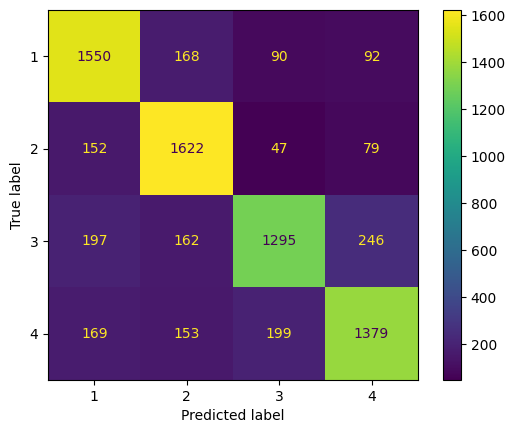

In [136]:
# KNeighborsClassifier trained on full train data and evaluated on test data

X_train_knn = train_df['processed_text']
y_train_knn = train_df['class']

X_test_knn = test_df['processed_text']
y_test_knn = test_df['class']

knn_pipeline.fit(X_train_knn, y_train_knn)
knn_predictions = knn_pipeline.predict(X_test_knn)

print(classification_report(y_test_knn, knn_predictions))
print(confusion_matrix(y_test_knn, knn_predictions))

### Evaluation of the Bidirectional LSTM model with Glove embeddings

In [115]:
# Compile and train the bidirectional_lstm model

# Define callback for early stopping
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=4, # number of epochs with no improvement
        verbose=1
    )
]

y_train = train_df['class'].apply(lambda x: x - 1).values
y_test = test_df['class'].apply(lambda x: x - 1).values

batch_size = 32
epochs = 10

bidirectional_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = bidirectional_lstm_model.fit(train_padded_sentences, y_train, batch_size=batch_size, epochs=epochs, validation_data=(test_padded_sentences, y_test), callbacks=callbacks)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 234s 61ms/step - accuracy: 0.9784 - loss: 0.0698 - val_accuracy: 0.9111 - val_loss: 0.4794
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 225s 60ms/step - accuracy: 0.9821 - loss: 0.0534 - val_accuracy: 0.9149 - val_loss: 0.7012
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 223s 59ms/step - accuracy: 0.9848 - loss: 0.0470 - val_accuracy: 0.9118 - val_loss: 0.7848
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 225s 60ms/step - accuracy: 0.9872 - loss: 0.0402 - val_accuracy: 0.9124 - val_loss: 1.0452
Epoch 4: early stopping


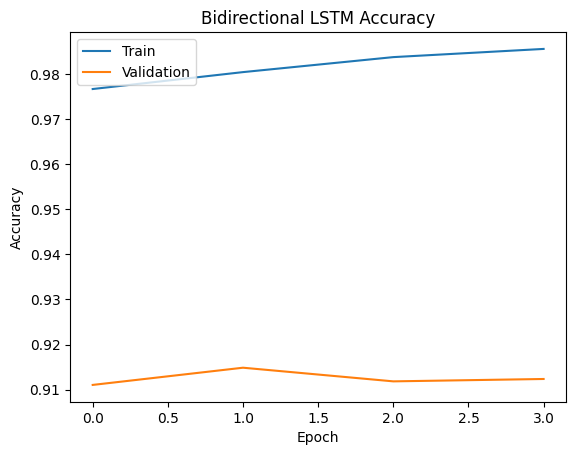

In [117]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bidirectional LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

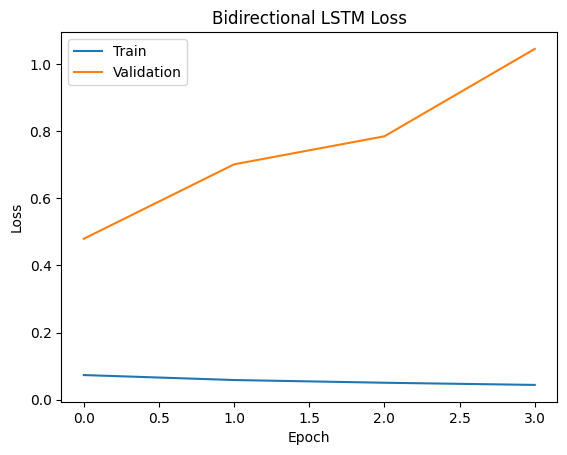

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [110]:
# Make prediction on the test set using the bidirectional LSTM model
predictions = [np.argmax(i) for i in bidirectional_lstm_model.predict(test_padded_sentences)]
# print(predictions[:5])

bidirectional_lstm_model_acc = accuracy_score(predictions, y_test)
# bidirectional_lstm_model_f1 = f1_score(y_test, predictions, average='micro')

print(f'Bidirectional LSTM Accuracy: {bidirectional_lstm_model_acc}')
# print(f'Bidirectional LSTM F1: {bidirectional_lstm_model_f1}')


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Bidirectional LSTM Accuracy: 0.9136842105263158


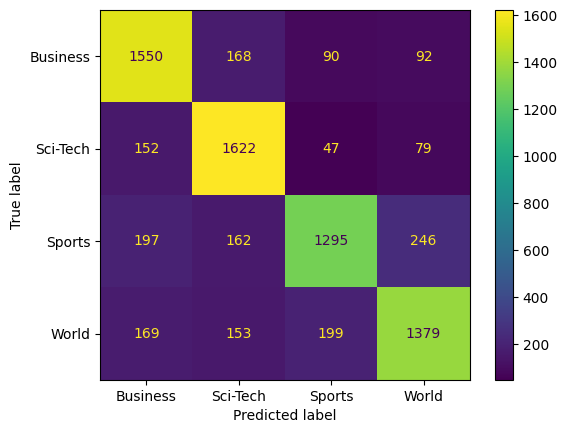

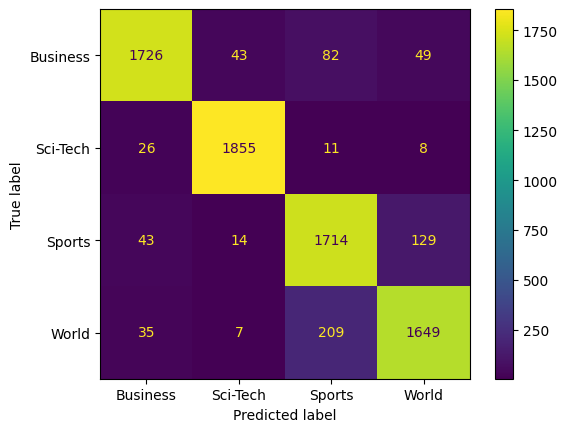

In [139]:
labels = ['Business', 'Sci-Tech', 'Sports', 'World']

disp = ConfusionMatrixDisplay.from_predictions(y_test_knn, knn_predictions, display_labels=labels)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=labels)

## Section 5 - Paper Overview

## Section 6 - Lbl2Vec Implementation

### Data Preparation for Lbl2Vec

In [90]:
# load labels with keywords
labels = pd.read_csv('ag_news_data/labels.csv',sep=';')

# split keywords by separator and save them as array
labels['keywords'] = labels['keywords'].apply(lambda x: x.split(' '))

# convert description keywords to lowercase
labels['keywords'] = labels['keywords'].apply(lambda description_keywords: [keyword.lower() for keyword in description_keywords])

# get number of keywords for each class
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

labels

,class_index,class_name,keywords,number_of_keywords
0,1,World,"[election, state, president, police, politics,...",11
1,2,Sports,"[olympic, football, sport, league, baseball, r...",32
2,3,Business,"[company, market, oil, consumers, exchange, bu...",10
3,4,Science/Technology,"[laboratory, computers, science, technology, w...",18


In [127]:
train_df['data_set_type'] = 'train'
test_df['data_set_type'] = 'test'

full_df = pd.concat([train_df, test_df]).reset_index(drop=True)

full_df.head()

,class,title,description,processed_text,data_set_type
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bears claw back black reuters reuters wal...,train
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace reut...,train
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks outlook reuters reute...,train
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline ...,train
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar record posing new menace us ec...,train


In [128]:
# Tag pre-processed documents using TaggedDocument
full_df['tagged_docs'] = full_df.apply(lambda row: TaggedDocument(row['processed_text'].split(' '), [str(row.name)]), axis=1)

In [129]:
# Add 'doc_key' column
full_df['doc_key'] = full_df.index.astype(str)

In [130]:
# Add 'class_name' column
full_df = full_df.merge(labels, left_on='class', right_on='class_index', how='left').drop(['class', 'keywords'], axis=1)

full_df.head()

,title,description,processed_text,data_set_type,tagged_docs,doc_key,class_index,class_name,number_of_keywords
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bears claw back black reuters reuters wal...,train,"([wall, bears, claw, back, black, reuters, reu...",0,3,Business,10
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace reut...,train,"([carlyle, looks, toward, commercial, aerospac...",1,3,Business,10
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks outlook reuters reute...,train,"([oil, economy, cloud, stocks, outlook, reuter...",2,3,Business,10
3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline ...,train,"([iraq, halts, oil, exports, main, southern, p...",3,3,Business,10
4,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar record posing new menace us ec...,train,"([oil, prices, soar, record, posing, new, mena...",4,3,Business,10


### Train Lbl2Vec model

In [131]:
# Instantiate and train the model
lbl2vec_model = Lbl2Vec(keywords_list=list(labels['keywords']), tagged_documents=full_df['tagged_docs'][full_df['data_set_type']=='train'], label_names=list(labels['class_name']), similarity_threshold=0.30, min_num_docs=100, epochs=10)
lbl2vec_model.fit()

2024-12-04 15:39:27,117 - Lbl2Vec - INFO - Train document and word embeddings
2024-12-04 15:39:27,117 - Lbl2Vec - INFO - Train document and word embeddings
2024-12-04 15:39:27,117 - Lbl2Vec - INFO - Train document and word embeddings
2024-12-04 15:41:09,841 - Lbl2Vec - INFO - Train label embeddings
2024-12-04 15:41:09,841 - Lbl2Vec - INFO - Train label embeddings
2024-12-04 15:41:09,841 - Lbl2Vec - INFO - Train label embeddings


## Section 7 - Evaluation of Lbl2Vec

### Evaluation of Lbl2Vec on the test set

In [132]:
test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=full_df['tagged_docs'][full_df['data_set_type']=='test'])
test_docs_lbl_similarities.head()

2024-12-04 15:43:45,358 - Lbl2Vec - INFO - Calculate document embeddings
2024-12-04 15:43:45,358 - Lbl2Vec - INFO - Calculate document embeddings
2024-12-04 15:43:45,358 - Lbl2Vec - INFO - Calculate document embeddings
2024-12-04 15:43:48,705 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-12-04 15:43:48,705 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-12-04 15:43:48,705 - Lbl2Vec - INFO - Calculate document<->label similarities


,doc_key,most_similar_label,highest_similarity_score,World,Sports,Business,Science/Technology
0,120000,Business,0.429345,0.361259,0.275473,0.429345,0.373688
1,120001,Science/Technology,0.414095,0.313178,0.404277,0.348802,0.414095
2,120002,Science/Technology,0.416546,0.220192,0.340958,0.375600,0.416546
3,120003,Sports,0.383362,0.330997,0.383362,0.339069,0.370195
4,120004,Science/Technology,0.452420,0.294172,0.295068,0.416666,0.452420


In [140]:
evaluation_test = test_docs_lbl_similarities.merge(full_df[full_df['data_set_type']=='test'], left_on='doc_key', right_on='doc_key')

y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']
print(classification_report(y_true_test, y_pred_test))
print('F1 score:',f1_score(y_true_test, y_pred_test, average='micro'))

                    precision    recall  f1-score   support

          Business       0.78      0.70      0.74      1900
Science/Technology       0.80      0.70      0.75      1900
            Sports       0.85      0.95      0.90      1900
             World       0.79      0.87      0.83      1900

          accuracy                           0.81      7600
         macro avg       0.80      0.81      0.80      7600
      weighted avg       0.80      0.81      0.80      7600

F1 score: 0.8056578947368421


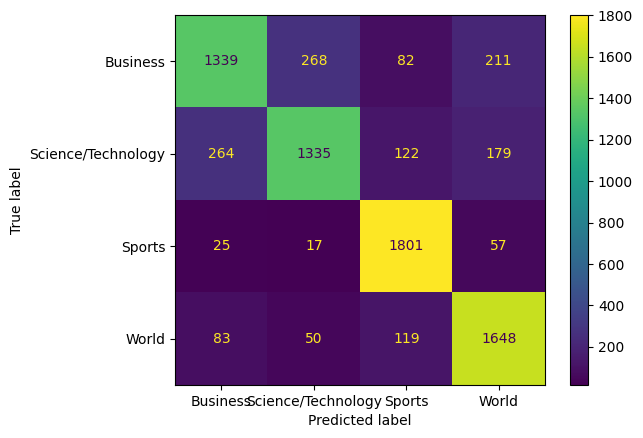

In [135]:
disp = ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test)